In [64]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter
import spacy
from gensim.models import KeyedVectors
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
nlp = spacy.load('en')

# LOAD DATA

In [2]:
w2v = KeyedVectors.load_word2vec_format(r'../../../wiki-news-300d-1M.vec')

In [6]:
# raw
project_data = pd.read_pickle(r'../Data/EWS_Published Project_Listing_DD.pkl')
news_data = pd.read_pickle(r'../Data/Feedly_Processed_DF_cleaned.pkl')
#labeled 
labeled_proj = pd.read_csv(r'../Data/Labeled_Data/projects.csv')
# stopwords
with open(r'stop_words.txt', 'r') as f:
    stop_words = set(f.read().strip().split("\n"))

In [16]:
# preprocess
project_data['Project Description'] = project_data['Project Description'].apply(lambda x: x if x != 'None' else None)
project_data['Project Description'].fillna('', inplace=True)
project_data['Project Name'].fillna('', inplace=True)

In [17]:
print(project_data.shape)
print(news_data.shape)
print(labeled_proj.shape)

(6839, 62)
(10674, 11)
(123, 9)


In [18]:
relevant_columns = ['Matched', 'title', 'ProjectNumber'] + news_data.columns.tolist() + ['Project Description']
relevant_col_news = ['article_id', 'content', 'article_text', 'summary', 'article_keywords', 'top_lang']
relevant_col_proj = ['Project Name', 'ProjectNumber', 'City', 'Country 1', 'Country 2'
                     , 'Country 3', 'Project Description', 'EWS ID']
merged_df = labeled_proj.merge(project_data[relevant_col_proj]).merge(news_data[relevant_col_news], left_on='article_id', right_on='article_id')

# create project embeddings

In [19]:
merged_df.columns

Index(['article_id', 'published', 'title', 'url', 'feed_label',
       'ProjectNumber', 'EWS Project Name', 'EWS hyperlink', 'Matched',
       'Project Name', 'City', 'Country 1', 'Country 2', 'Country 3',
       'Project Description', 'EWS ID', 'content', 'article_text', 'summary',
       'article_keywords', 'top_lang'],
      dtype='object')

In [22]:
project_embeddings_df = project_data[['ProjectNumber', 'Project Name', 'Project Description']].reset_index()

In [24]:
project_embeddings_df['spacy_text'] = project_embeddings_df.apply(lambda x:
                                                                  nlp(x['Project Name'] + ' '+ x['Project Description']), axis=1)

# create embeddings
To create an average embedding, project name and project description is concatenated, stop words are removed, and for each token, the fast text embedding is added into a list. We then take the mean of the list of vectors to create an n by 300 list of avg embeddings

In [56]:
def create_embedding(spac_text):
    embed=[]
    for tok in spac_text:
        if tok not in stop_words and tok.text.lower() in w2v:
            embed.append(w2v[tok.text.lower()])
    return np.mean(embed, axis=0) if len(embed) > 0 else None
project_embeddings_df['embeddings'] = project_embeddings_df['spacy_text'].apply(lambda x: create_embedding(x))

# Visualize avg embeddings in a 2 dimensional space

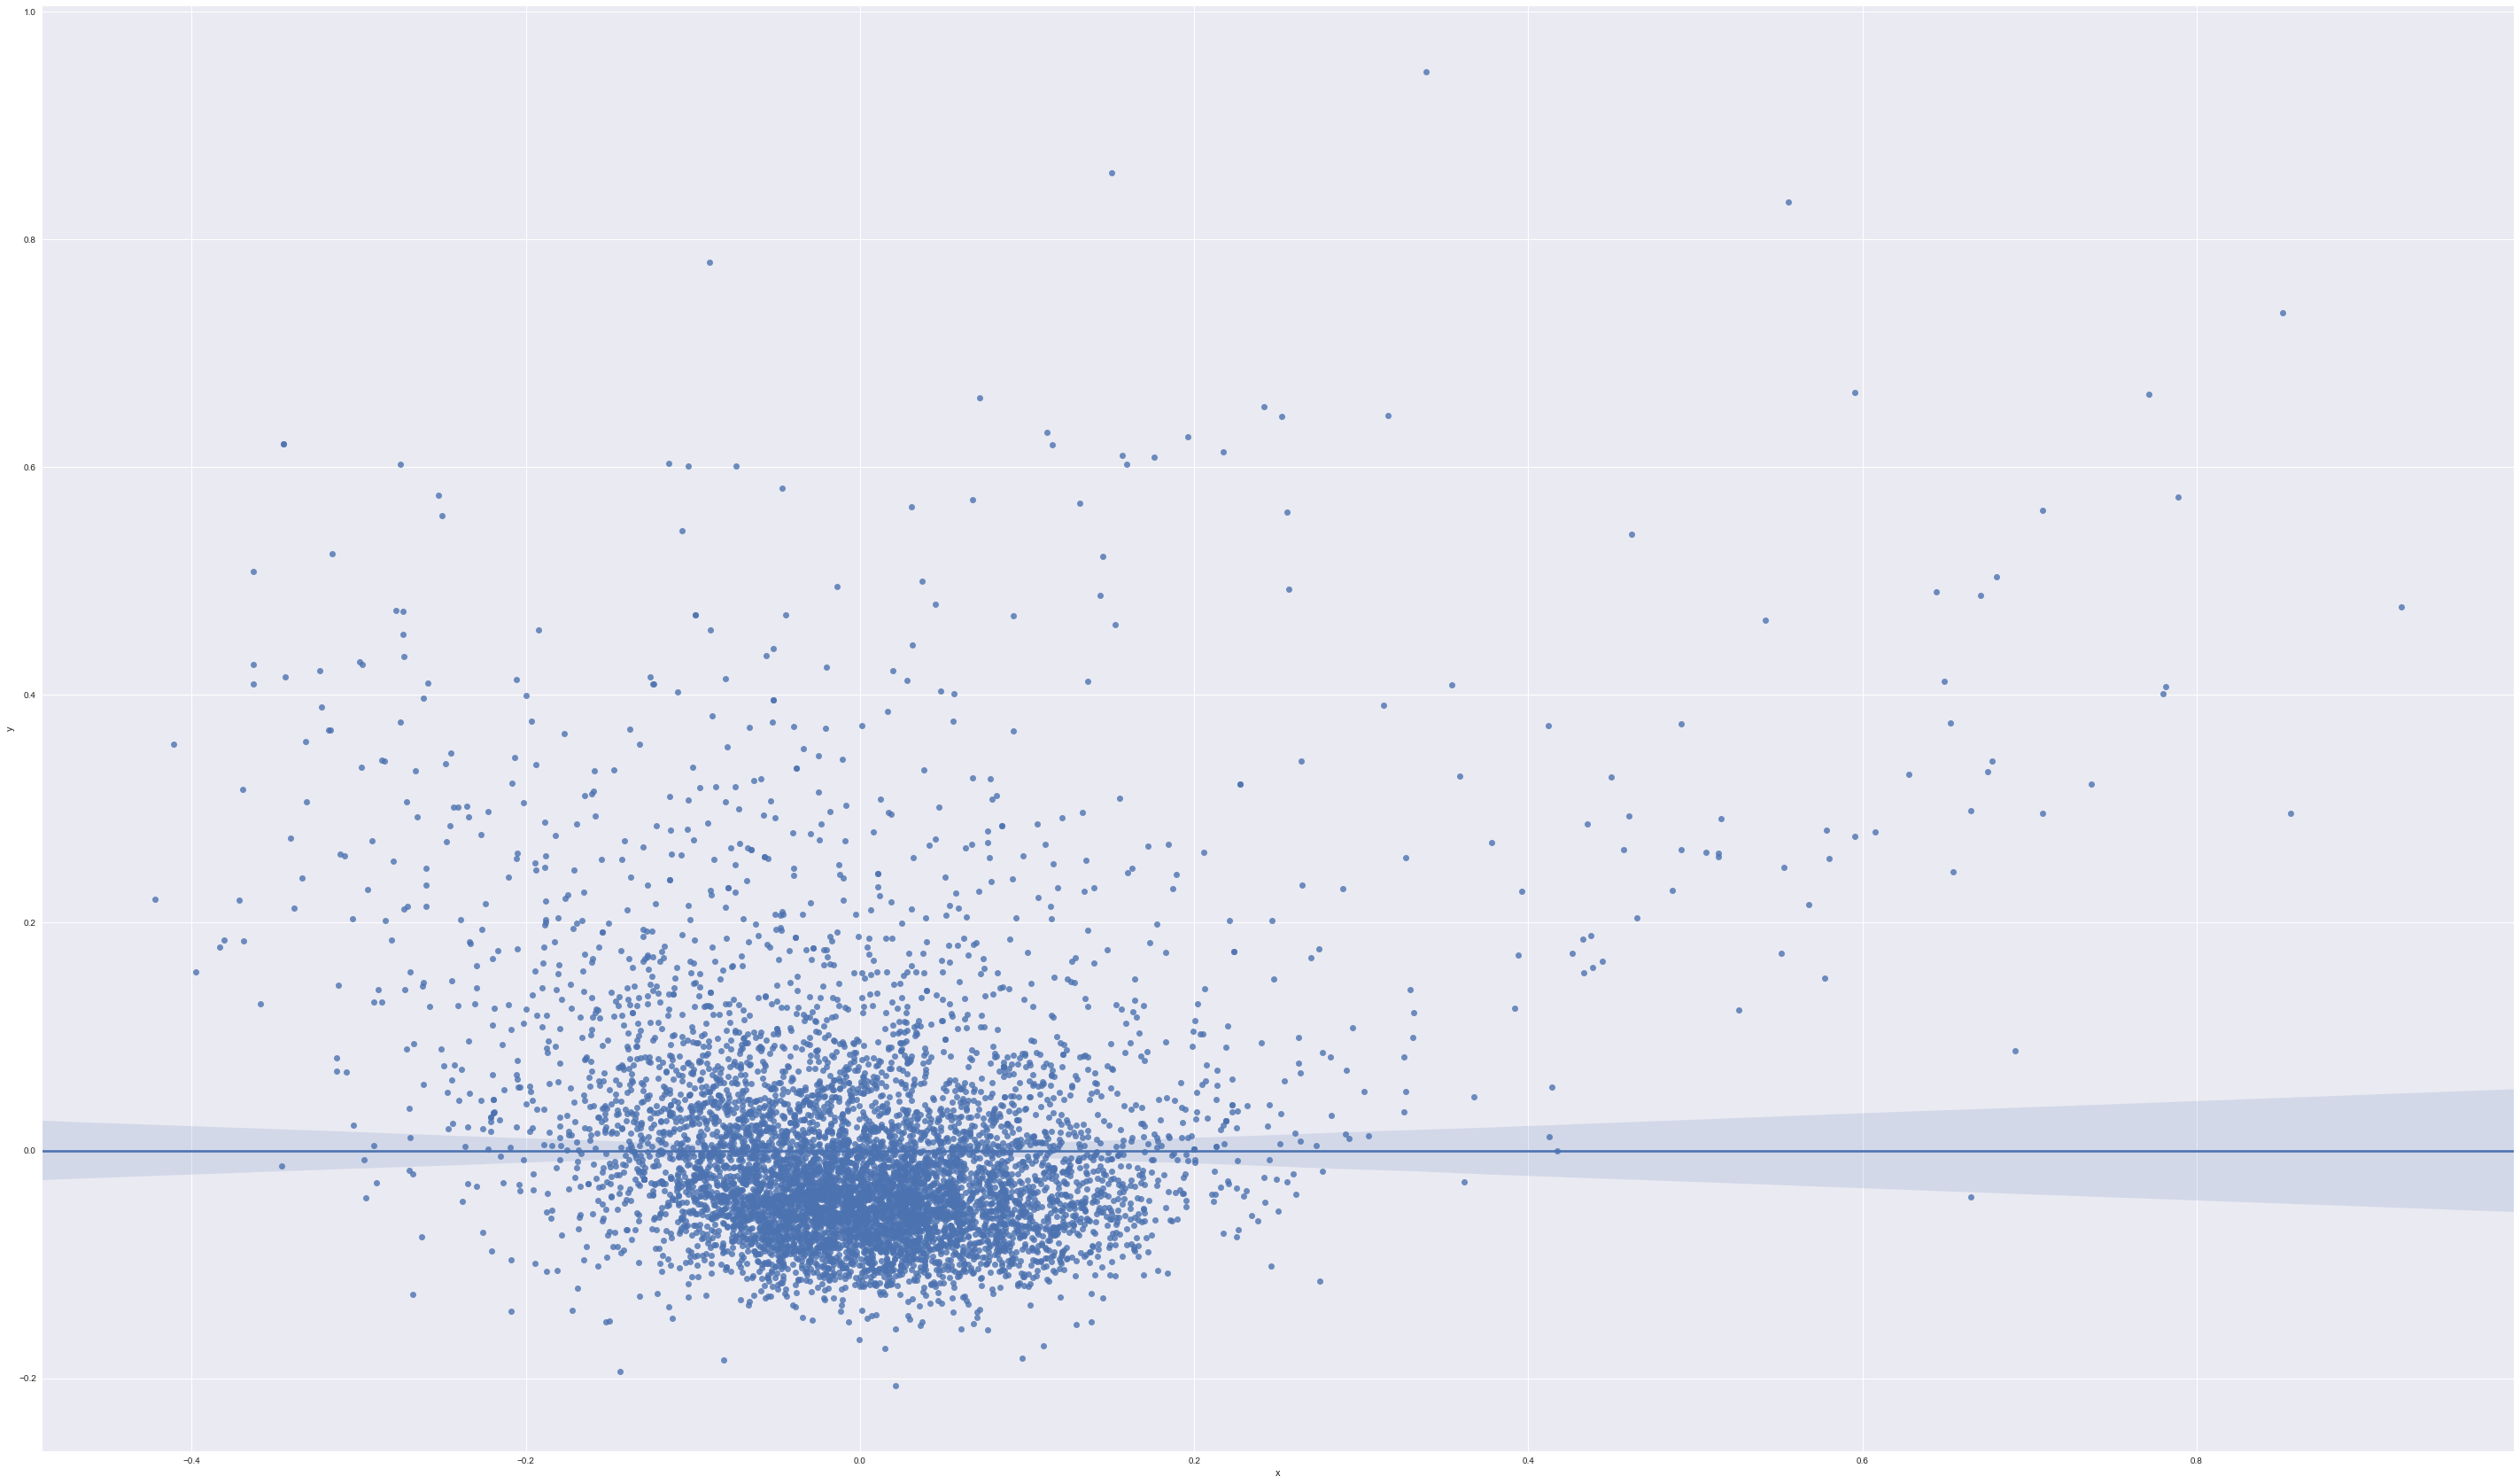

In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_embed = pca.fit_transform(project_embeddings_df[~project_embeddings_df['embeddings'].isnull()]['embeddings'].tolist())
pca_embed = pd.DataFrame(pca_embed, columns=['x','y'])
fig, ax = plt.subplots(figsize=(50,30))
sns.regplot(x='x',y='y',data=pca_embed)

In [67]:
merged_df['spac_art_text'] = merged_df['article_text'].apply(lambda x: nlp(x))

In [68]:
merged_df['art_text_embed'] = merged_df['spac_art_text'].apply(lambda x: create_embedding(x))

In [72]:
label_comparison = merged_df[merged_df['Matched'] == 1].merge(project_embeddings_df[['ProjectNumber', 'embeddings']])\
    .rename(index=str, columns={'embeddings': 'proj_embedding'})[['art_text_embed', 'proj_embedding']]

# check to make sure all embeddings are of size 300

In [84]:
assert all(len(x) == 300 for x in label_comparison['art_text_embed'].values)
assert all(len(x) == 300 for x in label_comparison['proj_embedding'].values)

In [90]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
label_comparison['Euclid'] = label_comparison.apply(lambda x: euclidean_distances(x['art_text_embed'].reshape(1, -1), x['proj_embedding'].reshape(1, -1))[0][0], axis=1)
label_comparison['Manhattan'] = label_comparison.apply(lambda x: manhattan_distances(x['art_text_embed'].reshape(1, -1), x['proj_embedding'].reshape(1, -1))[0][0], axis=1)
label_comparison['Cosine'] = label_comparison.apply(lambda x: cosine_distances(x['art_text_embed'].reshape(1, -1), x['proj_embedding'].reshape(1, -1))[0][0], axis=1)

# get distances

,Euclid,Manhattan,Cosine
count,79.000000,79.000000,79.000000
mean,0.351910,4.671888,0.059198
std,0.185253,2.460412,0.062642
min,0.162427,2.130729,0.011141
25%,0.236299,3.205428,0.023586
50%,0.285998,3.841765,0.035482
75%,0.404424,5.373910,0.067233
max,1.147651,15.727953,0.336760


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


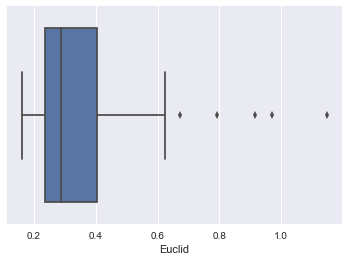

In [92]:
sns.boxplot(x=label_comparison["Euclid"])

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


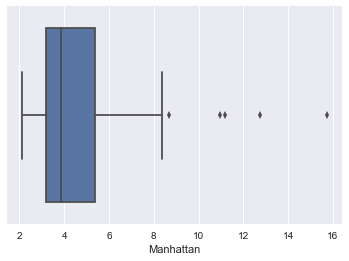

In [94]:
sns.boxplot(x=label_comparison["Manhattan"])

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


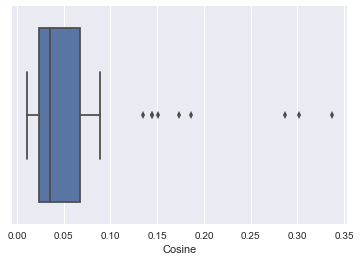

In [95]:
sns.boxplot(x=label_comparison["Cosine"])

In [122]:
# incorrect distances
incorrect_labels = merged_df.merge(project_embeddings_df[['ProjectNumber', 'embeddings']])\
    .rename(index=str, columns={'embeddings': 'proj_embedding'})[['ProjectNumber','spac_art_text','article_text','article_id','art_text_embed', 'proj_embedding']]

In [141]:
incorrect_data = []
for idx, row in incorrect_labels.iterrows():
    incorrect_data += incorrect_labels[incorrect_labels['ProjectNumber'] != row['ProjectNumber']][['ProjectNumber','spac_art_text','proj_embedding']].T.to_dict().values()
incorrect_data = pd.DataFrame(incorrect_data)

In [143]:
incorrect_data['bad_art_text_embed'] = incorrect_data['ProjectNumber'].apply(lambda x: create_embedding(incorrect_labels[incorrect_labels['ProjectNumber'] != x].sample(1, random_state=42)['spac_art_text'].values[0]))

In [144]:
incorrect_data['Euclid_bad'] = incorrect_data.apply(lambda x: euclidean_distances(x['bad_art_text_embed'].reshape(1, -1), x['proj_embedding'].reshape(1, -1))[0][0], axis=1)
incorrect_data['Manhattan_bad'] = incorrect_data.apply(lambda x: manhattan_distances(x['bad_art_text_embed'].reshape(1, -1), x['proj_embedding'].reshape(1, -1))[0][0], axis=1)
incorrect_data['Cosine_bad'] = incorrect_data.apply(lambda x: cosine_distances(x['bad_art_text_embed'].reshape(1, -1), x['proj_embedding'].reshape(1, -1))[0][0], axis=1)

In [145]:
incorrect_data[['Euclid_bad', 'Manhattan_bad', 'Cosine_bad']].describe()

,Euclid_bad,Manhattan_bad,Cosine_bad
count,5846.000000,5846.000000,5846.000000
mean,0.366925,4.932629,0.062491
std,0.172741,2.272727,0.056491
min,0.179541,2.405760,0.014521
25%,0.249443,3.426039,0.027590
50%,0.318449,4.384282,0.044475
75%,0.465313,6.194268,0.088926
max,1.181713,16.107720,0.324772


In [146]:
label_comparison[['Euclid', 'Manhattan', 'Cosine']].describe()

,Euclid,Manhattan,Cosine
count,79.000000,79.000000,79.000000
mean,0.351910,4.671888,0.059198
std,0.185253,2.460412,0.062642
min,0.162427,2.130729,0.011141
25%,0.236299,3.205428,0.023586
50%,0.285998,3.841765,0.035482
75%,0.404424,5.373910,0.067233
max,1.147651,15.727953,0.336760


# assign labels

In [179]:
proj_embed_dict = {x[0]: x[1] for x in project_embeddings_df[['ProjectNumber', 'embeddings']].values if x[1] is not None}

In [147]:
percentile = 15
pcnt = np.percentile(label_comparison['Euclid'], percentile)

In [103]:
news_subset = news_data.head(200)
news_subset['spac_text'] = news_subset['article_text'].apply(lambda x: nlp(x))

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [104]:
news_subset = news_subset.reset_index()

In [106]:
news_subset['embedding'] = news_subset['spac_text'].apply(lambda x: create_embedding(x))

In [180]:
def match_to_proj(embed):
    matches_to_dist = []
    for key in proj_embed_dict:
        euc_dis = euclidean_distances(embed.reshape(-1, 1), proj_embed_dict[key].reshape(-1, 1))[0][0]
        if euc_dis < pcnt:
            matches_to_dist.append((key, euc_dis))
    return None if len(matches_to_dist) == 0 else sorted(matches_to_dist, key=lambda tup: tup[1])[0]

In [ ]:
news_subset['matched_project'] = news_subset['embedding'].apply(lambda x: match_to_proj(x))

In [ ]:
news_subset['embedding']